# Project 2 - Housing Data
### Wesley Bosse - LA
###### 2/14/18

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, Imputer
from sklearn.pipeline import Pipeline, FeatureUnion # These ones are new!

sns.set_style('darkgrid')

%matplotlib inline

# EDA

In [2]:
#read in the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(2051, 82)

In [4]:
test.shape

(879, 80)

In [5]:
def data_cleaning(df):
    for column in df.columns:
        df.rename(columns={column: column.replace(' ', '')}, inplace=True)
        
    df['BsmtQual'].loc[df['BsmtQual'].isnull()] = 'NA'
    df['BsmtCond'].loc[df['BsmtCond'].isnull()] = 'NA'
    df['BsmtFinType1'].loc[df['BsmtFinType1'].isnull()] = 'NA'
    df['BsmtFinType2'].loc[df['BsmtFinType2'].isnull()] = 'NA'
    df['MiscFeature'].loc[df['MiscFeature'].isnull()] = 'NA'
    df['GarageType'].loc[df['GarageArea']==0] = 0

    df['GarageQual'].loc[df['GarageArea']==0] = 0
    df['GarageCond'].loc[df['GarageArea']==0] = 0

    df['GarageQual'].loc[df['GarageArea']!=0] = df['GarageQual'].value_counts().sort_values().index[-1]
    df['GarageCond'].loc[df['GarageArea']!=0] = df['GarageQual'].value_counts().sort_values().index[-1]
        
data_cleaning(train)
data_cleaning(test)

/Users/Wesley/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
train.drop(['MSSubClass', 'MSZoning', ], axis=1, inplace=True)
train = train.dropna(subset=['BsmtQual', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtFullBath', 'GarageCars','BsmtFinType2', 'Electrical'])
train.isnull().sum()

Id                  0
PID                 0
LotFrontage       330
LotArea             0
Street              0
Alley            1908
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemod/Add       0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType         22
MasVnrArea         22
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       998
GarageType          0
GarageYrBlt       113
GarageFinish      113
GarageCars          0
GarageArea          0
GarageQual          0
GarageCond          0
PavedDrive

In [7]:
# drop null rows from training data


In [8]:
def dummie_non_numeric(df):
    non_numeric_cols = list(set(df.columns)-set(df._get_numeric_data().sum().index))
    dummies = pd.get_dummies(df[non_numeric_cols])
    new = pd.concat([df, dummies], axis=1)
    return new

train = dummie_non_numeric(train)
test = dummie_non_numeric(test)

In [9]:
corr = train.corr()
sp_corr = corr['SalePrice'].sort_values(ascending=False)

neighborhood_index = []
fixed_neighborhood_index = []
for index in sp_corr.index:
    if index[:12] == 'Neighborhood':
        neighborhood_index.append(index)
        fixed_neighborhood_index.append(index[13:])
    
neighborhood_index

['Neighborhood_NridgHt',
 'Neighborhood_NoRidge',
 'Neighborhood_StoneBr',
 'Neighborhood_Somerst',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_ClearCr',
 'Neighborhood_GrnHill',
 'Neighborhood_NWAmes',
 'Neighborhood_Blmngtn',
 'Neighborhood_Gilbert',
 'Neighborhood_SawyerW',
 'Neighborhood_Greens',
 'Neighborhood_Landmrk',
 'Neighborhood_Blueste',
 'Neighborhood_Mitchel',
 'Neighborhood_NPkVill',
 'Neighborhood_SWISU',
 'Neighborhood_BrDale',
 'Neighborhood_MeadowV',
 'Neighborhood_BrkSide',
 'Neighborhood_Sawyer',
 'Neighborhood_Edwards',
 'Neighborhood_NAmes',
 'Neighborhood_IDOTRR',
 'Neighborhood_OldTown']

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
nc_scaled = min_max_scaler.fit_transform(pd.DataFrame(sp_corr[neighborhood_index]))
nc_normalized = pd.DataFrame(nc_scaled, index=sp_corr[neighborhood_index].index)
neighborhood_map = dict(zip(fixed_neighborhood_index, ((nc_normalized[0]+4.5)/5)**2))
neighborhood_map

{'Blmngtn': 0.94287805360940002,
 'Blueste': 0.91348522759483008,
 'BrDale': 0.87316028133939094,
 'BrkSide': 0.85223532410726088,
 'ClearCr': 0.95926478043197949,
 'CollgCr': 0.97710034035191129,
 'Crawfor': 0.96276799578356098,
 'Edwards': 0.82606899968658021,
 'Gilbert': 0.94231606482846586,
 'Greens': 0.93026354481909834,
 'GrnHill': 0.95114947148512174,
 'IDOTRR': 0.82037395326426865,
 'Landmrk': 0.92096964640365131,
 'MeadowV': 0.86393811674962062,
 'Mitchel': 0.90745781136282655,
 'NAmes': 0.82041538955152615,
 'NPkVill': 0.90068530663242075,
 'NWAmes': 0.94880336839481361,
 'NoRidge': 1.0891268816837283,
 'NridgHt': 1.2100000000000002,
 'OldTown': 0.81000000000000005,
 'SWISU': 0.8851965134438895,
 'Sawyer': 0.85144317447982187,
 'SawyerW': 0.93803079229932285,
 'Somerst': 1.0183136825762102,
 'StoneBr': 1.0850546748094829,
 'Timber': 0.99773767179725847,
 'Veenker': 0.97764907895550757}

In [11]:
train.replace({'Neighborhood':neighborhood_map},inplace=True)
test.replace({'Neighborhood':neighborhood_map},inplace=True)

In [12]:
# drop outliers from training data when house size > 4000sqft
train = train.drop(train.loc[train.GrLivArea > 4000].index)
train = train[np.abs(train.SalePrice-train.SalePrice.mean())<=(3*train.SalePrice.std())]

# Feature Engineering

House Size Score, House Quality Score, 

In [13]:
test.isnull().sum()

Id                    0
PID                   0
MSSubClass            0
MSZoning              0
LotFrontage         160
LotArea               0
Street                0
Alley               821
LotShape              0
LandContour           0
Utilities             0
LotConfig             0
LandSlope             0
Neighborhood          0
Condition1            0
Condition2            0
BldgType              0
HouseStyle            0
OverallQual           0
OverallCond           0
YearBuilt             0
YearRemod/Add         0
RoofStyle             0
RoofMatl              0
Exterior1st           0
Exterior2nd           0
MasVnrType            1
MasVnrArea            1
ExterQual             0
ExterCond             0
                   ... 
MasVnrType_None       0
MasVnrType_Stone      0
BsmtQual_Ex           0
BsmtQual_Fa           0
BsmtQual_Gd           0
BsmtQual_NA           0
BsmtQual_Po           0
BsmtQual_TA           0
Heating_Floor         0
Heating_GasA          0
Heating_GasW    

In [14]:
def feature_engineer(df):
    df['QualityAdjuster'] = (df['Neighborhood']+1)/2 * ((df['OverallQual']**2))

    df['AdjustedSize'] = \
        df['GrLivArea'] * df['QualityAdjuster']

    df['BathroomScore'] = \
        (df['FullBath']*2 + df['HalfBath']) * df['QualityAdjuster']

    df['GarageScore'] = \
        df['GarageCars'] * df['GarageArea'] 
    
    df['AdjGarageScore'] = \
        df['GarageScore'] * df['QualityAdjuster']
    
feature_engineer(train)
feature_engineer(test)

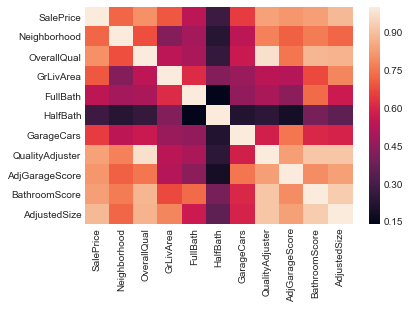

In [24]:
new_features = ['SalePrice','Neighborhood', 'OverallQual','GrLivArea','FullBath','HalfBath','GarageCars','QualityAdjuster', 'AdjGarageScore', 'BathroomScore', 'AdjustedSize']
corr = train[new_features].corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Regression

In [16]:
features = ['QualityAdjuster', 'AdjustedSize', 'BathroomScore', 'AdjGarageScore', 'GrLivArea','GarageType_Detchd', 'MasVnrType_None', 'GarageFinish_Unf', 'BsmtQual_TA', 'KitchenQual_TA', 'ExterQual_TA']
X = train[features]
y = train['SalePrice']

X_train, X_validate, y_train, y_validate = train_test_split(X, y, random_state=10)

ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_validate_scaled = ss.transform(X_validate)

lasso = Lasso()
cross_val_score(lasso, X_train_scaled, y_train).mean()

params = {
    'alpha': np.arange(.001, .15, .0025)
}
gs = GridSearchCV(lasso, params)
gs.fit(X_train_scaled, y_train)
print(gs.best_params_)
print(gs.score(X_validate_scaled, y_validate))

X_test = test[features]
X_test_scaled = ss.transform(X_test)

predictions = gs.predict(X_test_scaled)

test['SalePrice'] = predictions

test[['Id', 'SalePrice']].to_csv('reg_submission.csv', index=False)


{'alpha': 0.13600000000000001}
0.800681877816


# Classification

In [17]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

# test._get_numeric_data().isnull().sum()

# train = train.dropna(subset=['Yr Sold', 'Pool Area', 'Garage Cars', 'Fireplaces', 'Half Bath', 'Full Bath', 'Gr Liv Area', 'Total Bsmt SF', 'Overall Cond', 'Overall Qual', 'Lot Area', 'Bsmt Half Bath', 'Bsmt Full Bath'])

# train._get_numeric_data().isnull().sum()

# train['Sale Condition'].value_counts()

In [18]:


encoded_sale = {
    'Abnorml': 1,
    'Normal': 0,
    'Partial': 0,
    'Family':0,
    'Alloca':0,
    'AdjLand':0
}

train['SaleConditionEncoded'] = train['SaleCondition'].map(encoded_sale)

features = ['QualityAdjuster', 'AdjustedSize', 'BathroomScore', 'AdjGarageScore', 'GrLivArea','GarageType_Detchd', 'MasVnrType_None', 'GarageFinish_Unf', 'BsmtQual_TA', 'KitchenQual_TA', 'ExterQual_TA']
X = train[features]
y = train['SaleConditionEncoded']

X_train, X_validate, y_train, y_validate = train_test_split(X, y, random_state=1, stratify=y)

ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_validate_scaled = ss.transform(X_validate)

knn = KNeighborsClassifier()
cross_val_score(knn, X_train_scaled, y_train).mean()

params = {
    'n_neighbors': range(5,30),
    'weights': ['uniform', 'distance'],
    'p': [1,2]
}
gs = GridSearchCV(knn, params)
gs.fit(X_train_scaled, y_train)
print(gs.best_params_)
print(gs.score(X_validate_scaled, y_validate))

X_test = test[features]
X_test_scaled = ss.transform(X_test)

predictions = gs.predict(X_test_scaled)

test['Sale Condition'] = predictions

test[['Id', 'Sale Condition']].to_csv('classification_submission.csv', index=False)

df = pd.read_csv('classification_submission.csv')
df.head()



{'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}
0.936507936508


,Id,Sale Condition
0,2658,0
1,2718,0
2,2414,0
3,1989,0
4,625,0


# Visualizations

In [27]:
train.shape

(2013, 338)

# Scraping

In [33]:
import requests
from bs4 import BeautifulSoup

house_data = []
house_url_list = []
starting_url = 'https://www.zillow.com/ames-ia/sold/'
def scrape_area(url, iteration_counter):
    iteration_counter += 1
    res = requests.get(url)
    links = BeautifulSoup(res.content, 'html.parser').findAll('a', {'class': 'zsg-photo-card-overlay-link'})
    next_url = starting_url + '{}_p/'.format(iteration_counter)
    [house_url_list.append(starting_url + link.attrs.get('href')) for link in links]
    
    if iteration_counter <= 2:
        return scrape_area(next_url, iteration_counter)
    else:
        return house_url_list

def scrape_houses(url_list):
    missed_url_list = []
    for house in url_list:
            house_row = []
            soup = BeautifulSoup(requests.get(house).content, 'html.parser')
            details = soup.findAll('span', {'class': 'hdp-fact-value'})
            
            [house_row.append(detail.text) for detail in details]
            
            if house_row != []:
                house_row.append(house)
                house_data.append(house_row)
            else:
                missed_url_list.append(house)
                
    if len(missed_url_list) == 0:
        return house_data
    else:
        return scrape_houses(missed_url_list)
            
scrape_houses(scrape_area(starting_url, 1))

[]

# Modeling scraped data

In [ ]:


features = ['QualityAdjuster', 'AdjustedSize', 'BathroomScore', 'AdjGarageScore', 'GrLivArea','GarageType_Detchd', 'MasVnrType_None', 'GarageFinish_Unf', 'BsmtQual_TA', 'KitchenQual_TA', 'ExterQual_TA']
X = train[features]
y = train['SalePrice']

X_train, X_validate, y_train, y_validate = train_test_split(X, y, random_state=10)

ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_validate_scaled = ss.transform(X_validate)

lasso = Lasso()
cross_val_score(lasso, X_train_scaled, y_train).mean()

params = {
    'alpha': np.arange(.001, .15, .0025)
}
gs = GridSearchCV(lasso, params)
gs.fit(X_train_scaled, y_train)
print(gs.best_params_)
print(gs.score(X_validate_scaled, y_validate))